## 01 - Imports📦

In [4]:
!pip install category_encoders

In [5]:
import os
import json
import pandas as pd
import numpy as np
import pickle

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as stats

import category_encoders as ce

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split, cross_validate,learning_curve
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, IsolationForest
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression

import ipywidgets as widgets
from IPython.display import display


## 02 -  Load the Dataset 📂


In [6]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Insidium/cleaned_database.csv')

In [7]:
data

,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,reviews_por_mes,disponibilidade_365,ano_ultima_review,mes_ultima_review,dia_ultima_review
0,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225.0,1,45,0.380000,355,2019,5,21
1,Manhattan,Harlem,40.80902,-73.94190,Private room,150.0,3,0,1.373251,365,2018,6,16
2,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89.0,1,270,4.640000,194,2019,7,5
3,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80.0,10,9,0.100000,0,2018,11,19
4,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200.0,3,74,0.590000,129,2019,6,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...
48889,Brooklyn,Bedford-Stuyvesant,40.67853,-73.94995,Private room,70.0,2,0,1.373251,9,2018,6,16
48890,Brooklyn,Bushwick,40.70184,-73.93317,Private room,40.0,4,0,1.373251,36,2018,6,16
48891,Manhattan,Harlem,40.81475,-73.94867,Entire home/apt,115.0,10,0,1.373251,27,2018,6,16
48892,Manhattan,Hell's Kitchen,40.75751,-73.99112,Shared room,55.0,1,0,1.373251,2,2018,6,16


## 03 - Outliers Verification

### 03.1 - QQ-Plot Examination of Price Data: Assessing Normality

This QQ-plot visualizes the distribution of the 'price' column, which is the target variable for our machine learning model, against a theoretical normal distribution. If the data followed a normal distribution, the points would align approximately along the diagonal red line.

As observed, the plot reveals a significant deviation from normality, particularly in the higher quantiles. The curve in the upper right indicates a heavy right tail, suggesting that the dataset contains numerous values significantly higher than what a normal distribution would predict, and that there are outliers at the high end of the price range.

Checking the distribution of the target variable is crucial before addressing outliers because it directly impacts the choice of outlier detection methods.

- Methods like the Z-score assume a normal distribution, and using them on non-normal data can lead to inaccurate outlier identification.

- On the other hand, robust methods like IQR, DBSCAN, or Isolation Forest are better suited for skewed or non-normal data. This step is therefore an essential part of data preparation, ensuring that the data is adequately cleaned and prepared for reliable predictive modeling.

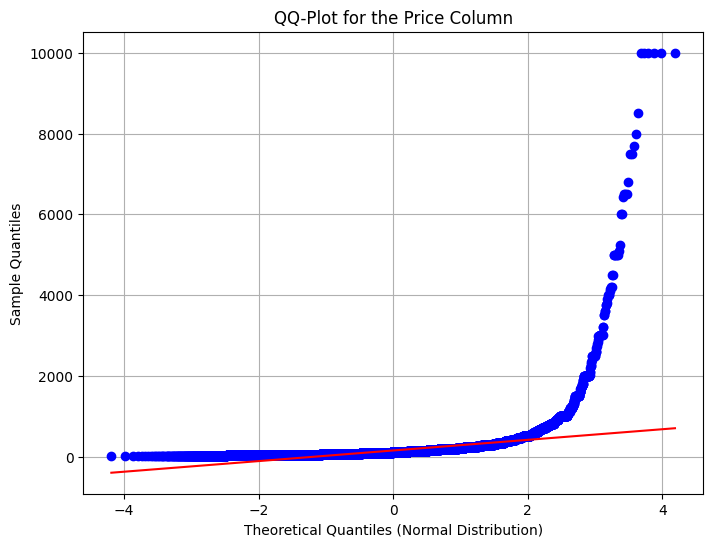

In [8]:
def plot_qq(x):
  plt.figure(figsize=(8, 6))
  stats.probplot(x, dist="norm", plot=plt)
  plt.title('QQ-Plot for the Price Column')
  plt.xlabel('Theoretical Quantiles (Normal Distribution)')
  plt.ylabel('Sample Quantiles')
  plt.grid(True)
  plt.show()

plot_qq(data['price'])

### 03.2 - Outliers Removal

In [9]:
data.shape

(48894, 13)

In [10]:
def remove_outliers_iqr(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]

    filtered_df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    print(f"Number of outliers found with IQR: {len(outliers)}")

    return filtered_df

data_iqr = remove_outliers_iqr(data, 'price')
print(f"Shape of dataframe after IQR outlier removal: {data_iqr.shape}")

Number of outliers found with IQR: 2972
Shape of dataframe after IQR outlier removal: (45922, 13)


In [11]:
def isolation_forest_outlier_check(x, contamination='auto'):
    isolation_forest = IsolationForest(contamination=contamination, random_state=42)
    isolation_forest.fit(x.values.reshape(-1, 1))
    outlier_labels = isolation_forest.predict(x.values.reshape(-1, 1))
    outlier_indices = np.where(outlier_labels == -1)[0]
    return outlier_indices

out_indx_isolation_forest = isolation_forest_outlier_check(data['price'])
print(f"Number of outliers found with Isolation Forest: {len(out_indx_isolation_forest)}")
data_isolation_forest = data.drop(out_indx_isolation_forest)
print(f"Shape of dataframe after Isolation Forest outlier removal: {data_isolation_forest.shape}")

Number of outliers found with Isolation Forest: 6338
Shape of dataframe after Isolation Forest outlier removal: (42556, 13)


In [12]:
data.describe()

,latitude,longitude,price,minimo_noites,numero_de_reviews,reviews_por_mes,disponibilidade_365,ano_ultima_review,mes_ultima_review,dia_ultima_review
count,48894.000000,48894.000000,48894.000000,48894.000000,48894.000000,48894.000000,48894.000000,48894.000000,48894.000000,48894.000000
mean,40.728951,-73.952169,152.755130,7.030085,23.274758,1.373251,112.776169,2018.228576,6.137808,15.831738
std,0.054529,0.046157,240.145697,20.510741,44.550991,1.497781,131.618692,1.059182,2.257870,8.808540
min,40.499790,-74.244420,10.000000,1.000000,0.000000,0.010000,0.000000,2011.000000,1.000000,1.000000
25%,40.690100,-73.983070,69.000000,1.000000,1.000000,0.280000,0.000000,2018.000000,6.000000,8.000000
50%,40.723075,-73.955680,106.000000,3.000000,5.000000,1.220000,45.000000,2019.000000,6.000000,16.000000
75%,40.763117,-73.936273,175.000000,5.000000,24.000000,1.580000,227.000000,2019.000000,7.000000,23.000000
max,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,365.000000,2019.000000,12.000000,31.000000


In [13]:
data_isolation_forest.describe()

,latitude,longitude,price,minimo_noites,numero_de_reviews,reviews_por_mes,disponibilidade_365,ano_ultima_review,mes_ultima_review,dia_ultima_review
count,42556.000000,42556.000000,42556.000000,42556.000000,42556.000000,42556.000000,42556.000000,42556.000000,42556.000000,42556.000000
mean,40.728399,-73.949998,112.587774,6.787198,24.398886,1.375526,106.936907,2018.223494,6.140709,15.852171
std,0.055575,0.046203,56.156589,19.998965,45.863624,1.525524,129.321499,1.074603,2.278802,8.899632
min,40.499790,-74.244420,35.000000,1.000000,0.000000,0.010000,0.000000,2011.000000,1.000000,1.000000
25%,40.688850,-73.980790,65.000000,1.000000,1.000000,0.260000,0.000000,2018.000000,6.000000,8.000000
50%,40.721025,-73.953730,100.000000,2.000000,6.000000,1.150000,36.000000,2019.000000,6.000000,16.000000
75%,40.763750,-73.933680,150.000000,5.000000,25.000000,1.630000,208.000000,2019.000000,7.000000,23.000000
max,40.913060,-73.712990,255.000000,1250.000000,629.000000,58.500000,365.000000,2019.000000,12.000000,31.000000


In [14]:
data_iqr.describe()

,latitude,longitude,price,minimo_noites,numero_de_reviews,reviews_por_mes,disponibilidade_365,ano_ultima_review,mes_ultima_review,dia_ultima_review
count,45922.00000,45922.000000,45922.000000,45922.00000,45922.000000,45922.000000,45922.000000,45922.000000,45922.000000,45922.000000
mean,40.72849,-73.950733,120.006278,6.93820,23.942990,1.377253,109.373133,2018.228670,6.134881,15.841100
std,0.05533,0.046471,68.127336,19.85802,45.315659,1.516931,130.275350,1.065235,2.268744,8.865176
min,40.49979,-74.244420,10.000000,1.00000,0.000000,0.010000,0.000000,2011.000000,1.000000,1.000000
25%,40.68924,-73.981928,65.000000,1.00000,1.000000,0.270000,0.000000,2018.000000,6.000000,8.000000
50%,40.72177,-73.954365,100.000000,2.00000,5.000000,1.180000,39.000000,2019.000000,6.000000,16.000000
75%,40.76339,-73.934313,159.000000,5.00000,24.000000,1.620000,217.000000,2019.000000,7.000000,23.000000
max,40.91306,-73.712990,334.000000,1250.00000,629.000000,58.500000,365.000000,2019.000000,12.000000,31.000000


In the development of a robust and accurate rental property price prediction model, careful consideration was given to the identification and handling of outliers. Outliers, or data points significantly deviating from the typical pattern, can distort model training and lead to inaccurate predictions.

Following an analysis of the target variable `price` using a QQ-plot, a substantial deviation from a normal distribution was observed, particularly with a heavy right tail. This indicates the presence of extreme values that could disproportionately influence traditional outlier detection methods like the Interquartile Range (IQR).

To address this, Isolation Forest was selected as the preferred outlier detection technique. This algorithm excels in identifying anomalies within complex and high-dimensional datasets, which is often characteristic of real estate data. Unlike methods relying on statistical assumptions about data distribution, Isolation Forest leverages an isolation-based approach, isolating outliers based on their dissimilarity from the majority of data points.

This approach is particularly suitable for rental property data, where factors like location, amenities, and market fluctuations contribute to intricate price patterns. Isolation Forest's ability to handle non-normality and capture diverse outlier types makes it a robust and reliable choice for enhancing the accuracy and stability of our prediction model.

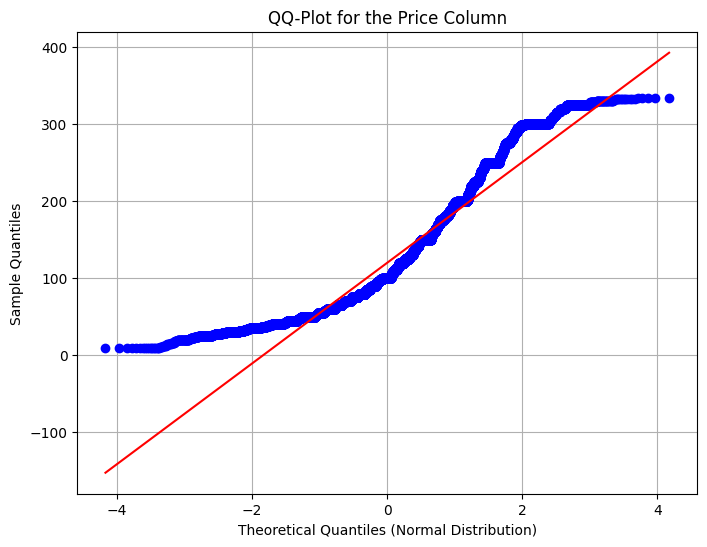

In [15]:
plot_qq(data_iqr['price'])

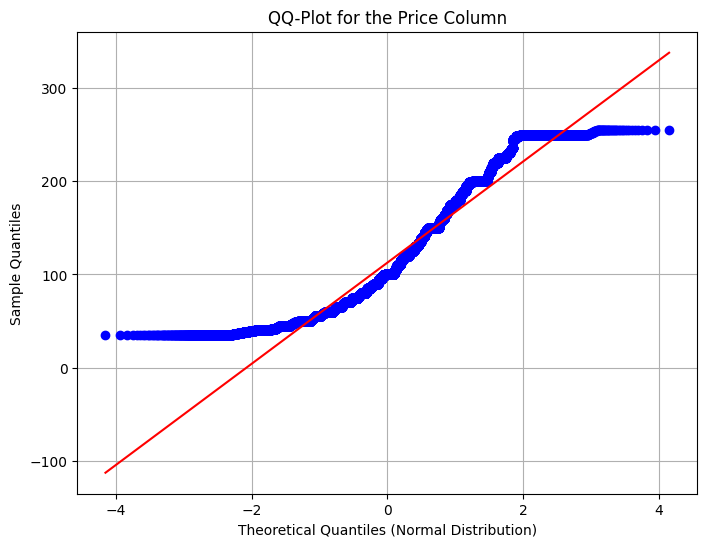

In [16]:
plot_qq(data_isolation_forest['price'])

## 04 - Feature Engineering: Categorical Encoding

In [17]:
len(data_isolation_forest.bairro.unique())



169

In [18]:
len(data_isolation_forest.room_type.unique())


3

In [19]:
len(data_isolation_forest.bairro_group.unique())


5

In [20]:
data_isolation_forest.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42556 entries, 0 to 48893
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   bairro_group         42556 non-null  object 
 1   bairro               42556 non-null  object 
 2   latitude             42556 non-null  float64
 3   longitude            42556 non-null  float64
 4   room_type            42556 non-null  object 
 5   price                42556 non-null  float64
 6   minimo_noites        42556 non-null  int64  
 7   numero_de_reviews    42556 non-null  int64  
 8   reviews_por_mes      42556 non-null  float64
 9   disponibilidade_365  42556 non-null  int64  
 10  ano_ultima_review    42556 non-null  int64  
 11  mes_ultima_review    42556 non-null  int64  
 12  dia_ultima_review    42556 non-null  int64  
dtypes: float64(4), int64(6), object(3)
memory usage: 4.5+ MB


### 04.1 - Encoding - Categorical Features

Why Target Encoding and One-Hot Encoding were chosen over Label Encoding:

Target Encoding for "bairro" (neighborhood):
- "bairro" has high cardinality (many unique values). One-Hot Encoding would lead to a significant increase in dimensionality, potentially harming model performance.
- Target Encoding captures the relationship between "bairro" and the target variable ("price") by replacing each category with the average price for that category.
- Overfitting is mitigated through regularization and cross-validation.

One-Hot Encoding for "bairro_group" and "room_type":
- These features have low cardinality, making One-Hot Encoding suitable as it introduces a manageable number of new columns.
- One-Hot Encoding allows the model to capture non-linear relationships between the categorical variables and the target, enhancing predictive power.
- It preserves interpretability, as each new column represents a specific category.

Avoiding Label Encoding:
- Crucially, Label Encoding assigns numerical values to categories, potentially creating an undesirable artificial hierarchy. For instance, if "Manhattan" is assigned 1 and "Brooklyn" 2, the model might misinterpret this as "Brooklyn" being "greater" than "Manhattan."
- It can be problematic for distance-based models like KNN, as numerical differences between encoded categories can distort distance calculations.
- It doesn't effectively capture non-linear relationships, unlike One-Hot Encoding.

In summary:

The selected encoding strategies are chosen to optimize the representation of categorical variables and enhance the model's predictive performance, while considering the data's characteristics and the strengths of each technique. Target Encoding leverages the direct relationship between "bairro" and "price," while One-Hot Encoding enables the model to explore complex relationships with other categorical variables.

In [21]:
def one_hot_encode(df, categorical_cols):
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='if_binary')
    preprocessor = ColumnTransformer(
        transformers=[
            ('onehot', ohe, categorical_cols)
        ],
        remainder='passthrough'
    )
    encoded_array = preprocessor.fit_transform(df)
    encoded_columns = preprocessor.get_feature_names_out()
    df_encoded = pd.DataFrame(encoded_array, columns=encoded_columns)
    return df_encoded, preprocessor


In [22]:
def target_encode(df, target_column, target_col):
    encoder = ce.TargetEncoder(cols=[target_col])
    df[f'{target_col}_encoded'] = encoder.fit_transform(df[target_col], df[target_column])
    bairro_mapping = dict(zip(df[target_col], df[f'{target_col}_encoded']))

    df.drop(target_col, axis=1, inplace=True)
    return df, encoder, bairro_mapping


In [23]:
def label_encode(df, categorical_cols):
    le = LabelEncoder()
    for col in categorical_cols:
        df[col] = le.fit_transform(df[col])
    return df, le

In [24]:
def apply_encoding(df, target_column='price'):
    categorical_cols = ['bairro_group', 'room_type']

    df_target, target_encoder, bairro_mapping  = target_encode(df, target_column, 'bairro')
    df_encoded, ohe_preprocessor = one_hot_encode(df_target, categorical_cols)

    new_columns = []
    for col in df_encoded.columns:
          if col.startswith('onehot__'):
              new_columns.append(col.replace('onehot__', ''))
          elif col.startswith('remainder__'):
              new_columns.append(col.replace('remainder__', ''))
          else:
              new_columns.append(col)
    df_encoded.columns = new_columns


    return df_encoded, target_encoder, ohe_preprocessor, bairro_mapping

In [25]:
def save_encoders(data,
                  target_encoder_path='/content/drive/MyDrive/Colab Notebooks/Insidium/models/target_encoder.pkl',
                  ohe_encoder_path='/content/drive/MyDrive/Colab Notebooks/Insidium/models/ohe_encoder.pkl',
                  target_column='price'):

  df_encoded, target_encoder, ohe_preprocessor, bairro_mapping = apply_encoding(data, target_column)

  os.makedirs(os.path.dirname(target_encoder_path), exist_ok=True)
  os.makedirs(os.path.dirname(ohe_encoder_path), exist_ok=True)

  with open(target_encoder_path, 'wb') as f:
    pickle.dump(target_encoder, f)

  with open(ohe_encoder_path, 'wb') as f:
     pickle.dump(ohe_preprocessor, f)
  return df_encoded, bairro_mapping



In [26]:
data_encoded, bairro_mapping = save_encoders(data_isolation_forest)


In [27]:
bairro_mapping

{'Midtown': 159.3131634819533,
 'Harlem': 99.15975855130785,
 'Clinton Hill': 118.11867704280155,
 'East Harlem': 106.75722543352602,
 'Murray Hill': 163.63717602593283,
 'Bedford-Stuyvesant': 93.41971287514525,
 "Hell's Kitchen": 145.01181102362204,
 'Upper West Side': 135.05227552275522,
 'Chinatown': 128.23999999999913,
 'South Slope': 126.84883720864475,
 'West Village': 175.14468864468864,
 'Williamsburg': 115.23539152612629,
 'Fort Greene': 125.32118451025057,
 'Chelsea': 159.3411910669975,
 'Crown Heights': 95.69446391030134,
 'Park Slope': 135.38268792710707,
 'Windsor Terrace': 117.0992656984435,
 'Inwood': 86.03765691195066,
 'East Village': 139.3758774728781,
 'Greenpoint': 118.933935265823,
 'Bushwick': 80.2784645140831,
 'Flatbush': 82.52430555555556,
 'Lower East Side': 133.54060913705584,
 'Prospect-Lefferts Gardens': 94.1304347826087,
 'Long Island City': 106.18346774193549,
 'Kips Bay': 139.38069705093835,
 'SoHo': 153.40663899384663,
 'Upper East Side': 140.5035324341

In [29]:
data_encoded.columns

Index(['bairro_group_Bronx', 'bairro_group_Brooklyn', 'bairro_group_Manhattan',
       'bairro_group_Queens', 'bairro_group_Staten Island',
       'room_type_Entire home/apt', 'room_type_Private room',
       'room_type_Shared room', 'latitude', 'longitude', 'price',
       'minimo_noites', 'numero_de_reviews', 'reviews_por_mes',
       'disponibilidade_365', 'ano_ultima_review', 'mes_ultima_review',
       'dia_ultima_review', 'bairro_encoded'],
      dtype='object')

In [30]:
data_encoded.head()

,bairro_group_Bronx,bairro_group_Brooklyn,bairro_group_Manhattan,bairro_group_Queens,bairro_group_Staten Island,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,latitude,longitude,price,minimo_noites,numero_de_reviews,reviews_por_mes,disponibilidade_365,ano_ultima_review,mes_ultima_review,dia_ultima_review,bairro_encoded
0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,40.75362,-73.98377,225.0,1.0,45.0,0.380000,355.0,2019.0,5.0,21.0,159.313163
1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,40.80902,-73.94190,150.0,3.0,0.0,1.373251,365.0,2018.0,6.0,16.0,99.159759
2,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,40.68514,-73.95976,89.0,1.0,270.0,4.640000,194.0,2019.0,7.0,5.0,118.118677
3,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,40.79851,-73.94399,80.0,10.0,9.0,0.100000,0.0,2018.0,11.0,19.0,106.757225
4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,40.74767,-73.97500,200.0,3.0,74.0,0.590000,129.0,2019.0,6.0,22.0,163.637176


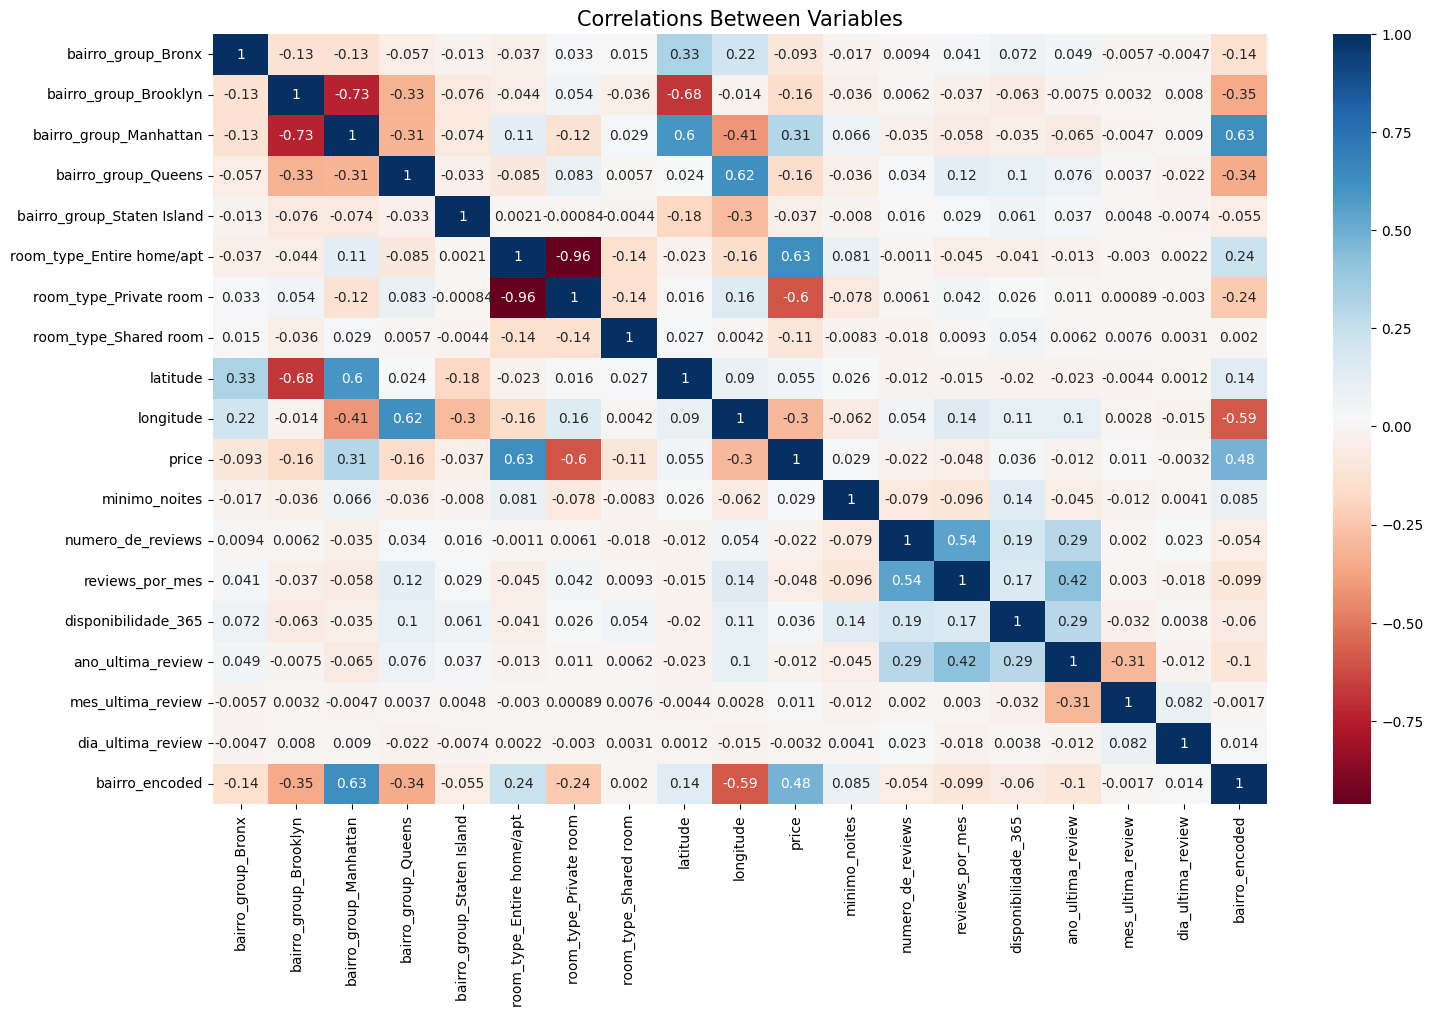

In [31]:
plt.figure(figsize=(17,10))
sns.heatmap(data_encoded.corr(),annot=True, cmap="RdBu")
plt.title("Correlations Between Variables", size=15)
plt.show()

The correlation matrices before and after applying target encoding and one-hot encoding show notable differences, particularly in the correlations involving the categorical variables (bairro_group and room_type). Before encoding, these variables showed very little correlation with price and other numerical features, while after encoding, these correlations become stronger and more informative. This highlights how proper encoding of categorical variables is critical in correlation analysis.

In [32]:
data_encoded.describe()

,bairro_group_Bronx,bairro_group_Brooklyn,bairro_group_Manhattan,bairro_group_Queens,bairro_group_Staten Island,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,latitude,longitude,price,minimo_noites,numero_de_reviews,reviews_por_mes,disponibilidade_365,ano_ultima_review,mes_ultima_review,dia_ultima_review,bairro_encoded
count,42556.000000,42556.000000,42556.000000,42556.000000,42556.000000,42556.000000,42556.000000,42556.000000,42556.000000,42556.000000,42556.000000,42556.000000,42556.000000,42556.000000,42556.000000,42556.000000,42556.000000,42556.000000,42556.000000
mean,0.022840,0.431925,0.415147,0.122521,0.007567,0.482024,0.498614,0.019363,40.728399,-73.949998,112.587774,6.787198,24.398886,1.375526,106.936907,2018.223494,6.140709,15.852171,112.920848
std,0.149397,0.495350,0.492753,0.327890,0.086657,0.499683,0.500004,0.137798,0.055575,0.046203,56.156589,19.998965,45.863624,1.525524,129.321499,1.074603,2.278802,8.899632,26.652560
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,40.499790,-74.244420,35.000000,1.000000,0.000000,0.010000,0.000000,2011.000000,1.000000,1.000000,64.408124
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,40.688850,-73.980790,65.000000,1.000000,1.000000,0.260000,0.000000,2018.000000,6.000000,8.000000,93.419713
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,40.721025,-73.953730,100.000000,2.000000,6.000000,1.150000,36.000000,2019.000000,6.000000,16.000000,106.757225
75%,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,40.763750,-73.933680,150.000000,5.000000,25.000000,1.630000,208.000000,2019.000000,7.000000,23.000000,135.382688
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,40.913060,-73.712990,255.000000,1250.000000,629.000000,58.500000,365.000000,2019.000000,12.000000,31.000000,179.116747


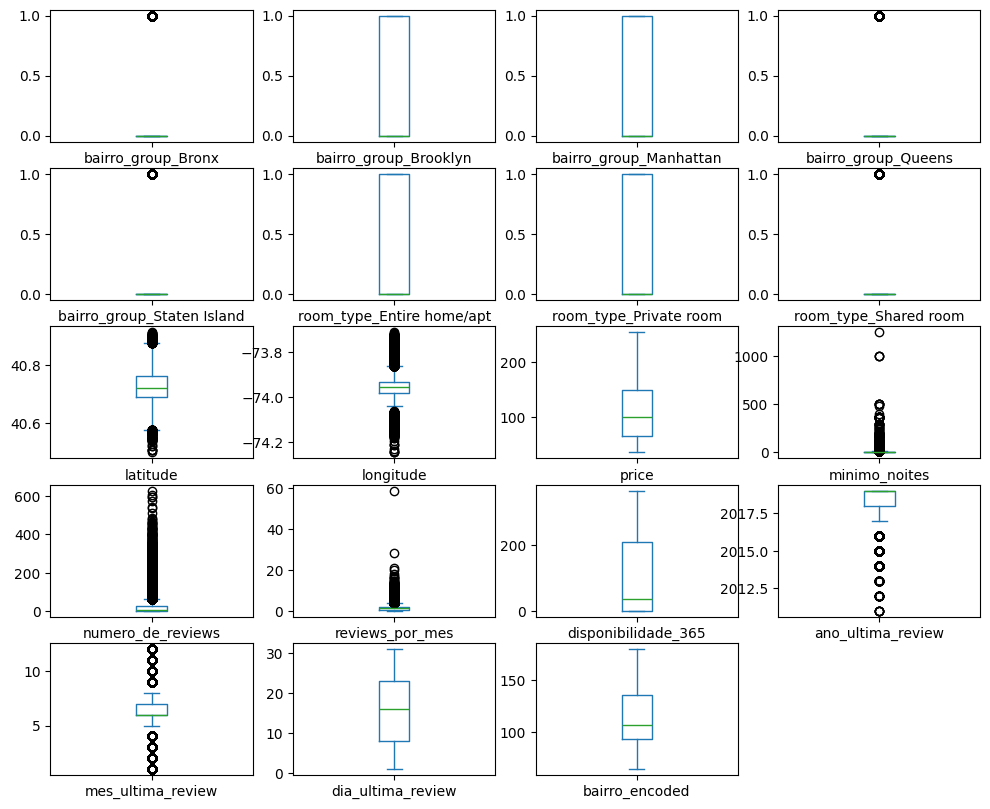

In [33]:
data_encoded.plot(kind='box', subplots=True, layout=(6, 4), figsize=(12, 12))
plt.show()

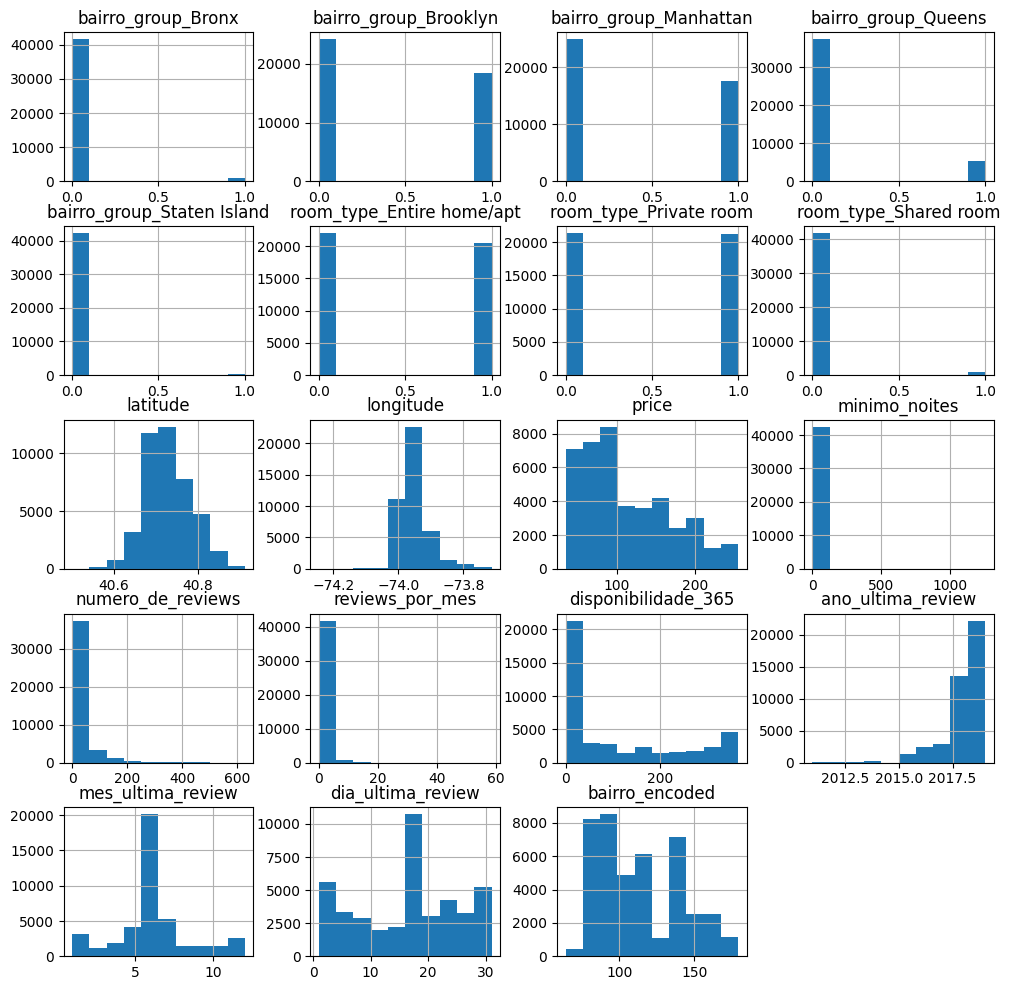

In [34]:
data_encoded.hist(figsize=(12, 12))
plt.show()

## 05 - Training

**Why Regression?**

We use regression because the goal is to predict the rent price, which is a continuous value, meaning it can take on a wide range of numerical values. Regression is the appropriate type of Machine Learning model for predicting continuous values.

In [35]:
X = data_encoded.drop('price', axis=1)
y = data_encoded['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [36]:
def plot_model_evaluation(model, X_train, y_train, X_test, y_test, threshold=100):

    train_sizes, train_scores, val_scores = learning_curve(model, X_train, y_train, cv=5)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    val_scores_mean = np.mean(val_scores, axis=1)
    val_scores_std = np.std(val_scores, axis=1)

    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, val_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, val_scores_mean - val_scores_std, val_scores_mean + val_scores_std, alpha=0.1, color="g")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.title("Learning Curve")
    plt.legend(loc="best")
    plt.show()

    y_pred = model.predict(X_test)
    differences = abs(y_test - y_pred)
    correct_predictions = differences <= threshold
    incorrect_predictions = differences > threshold

    plt.figure(figsize=(10, 6))
    plt.hist(differences[correct_predictions], bins=20, alpha=0.5, label='Correct Predictions')
    plt.hist(differences[incorrect_predictions], bins=20, alpha=0.5, label='Incorrect Predictions')
    plt.xlabel('Absolute Difference (True - Predicted)')
    plt.ylabel('Number of Predictions')
    plt.title(f'Prediction Accuracy for {model.__class__.__name__}')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

    residuals = y_test - y_pred
    plt.figure(figsize=(8, 6))
    plt.scatter(y_pred, residuals)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.title(f"Residual Plot for {model.__class__.__name__}")
    plt.show()

In [37]:
def evaluate_model(model, X_test, y_test):
  model_name = model.__class__.__name__
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  rmse = np.sqrt(mean_squared_error(y_test, y_pred))
  mae = mean_absolute_error(y_test, y_pred)
  mse = mean_squared_error(y_test, y_pred)
  r2 = r2_score(y_test, y_pred)
  pve = explained_variance_score(y_test, y_pred)

  print(f"Results for {model_name}:")
  print(f"  RMSE: {rmse:.4f}")
  print(f"  MAE: {mae:.4f}")
  print(f"  MSE: {mse:.4f}")
  print(f"  R²: {r2:.4f}")
  print(f"  PVE: {pve:.4f}")
  print("-" * 50)
  plot_model_evaluation(model, X_train, y_train, X_test, y_test)

  return [rmse, mae, mse, r2, pve]

**Metric Calculation: The function (evaluate_model) calculates several evaluation metrics, including:**

- RMSE (Root Mean Squared Error): Measures the average difference between predictions and actual values, penalizing larger errors.
- MAE (Mean Absolute Error): Measures the average absolute difference between predictions and actual values.
- MSE (Mean Squared Error): Similar to RMSE but without the square root.
- R² (R-squared): Indicates the proportion of variance in the target variable that is explained by the model.
- PVE (Proportion of Variance Explained): Similar to R² but considering the total variance in the data.

In summary:

- RMSE, MAE, and MSE: The lower the value, the better the model. Indicate lower error in predictions.
- R² and PVE: The higher the value, the better the model. Indicate greater ability to explain variance in the target variable.

### 05.1 - RandomForest

Results for RandomForestRegressor:
  RMSE: 36.8352
  MAE: 27.7602
  MSE: 1356.8299
  R²: 0.5730
  PVE: 0.5736
--------------------------------------------------


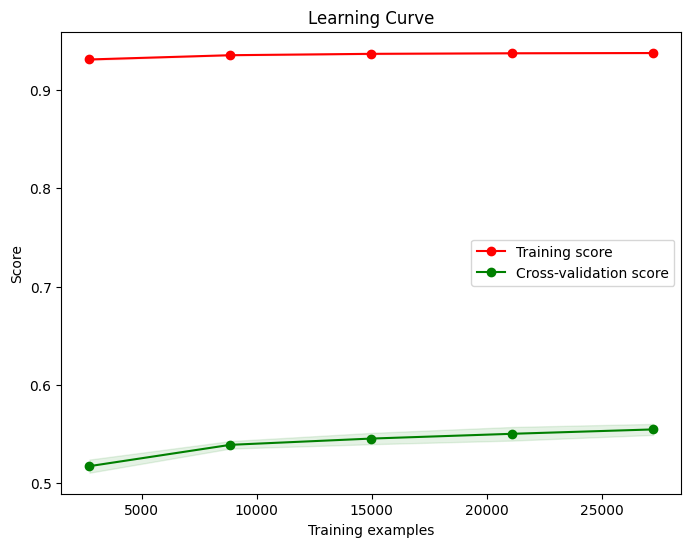

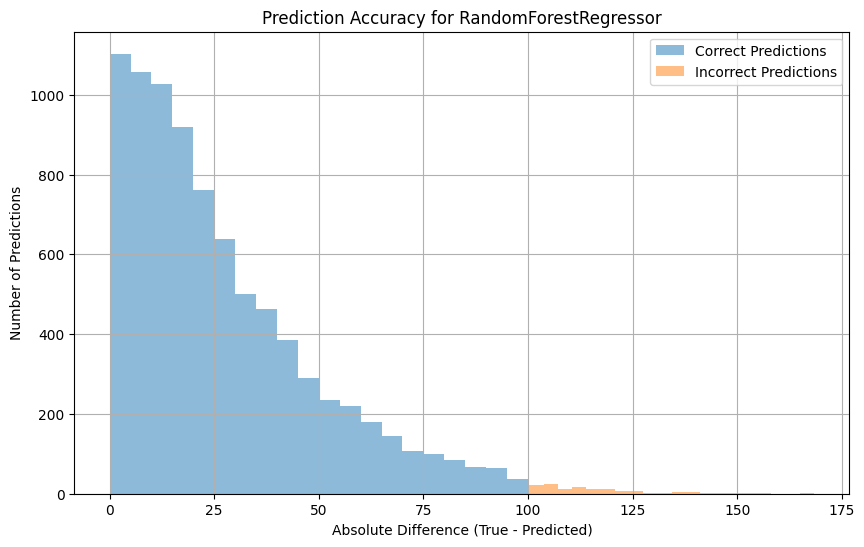

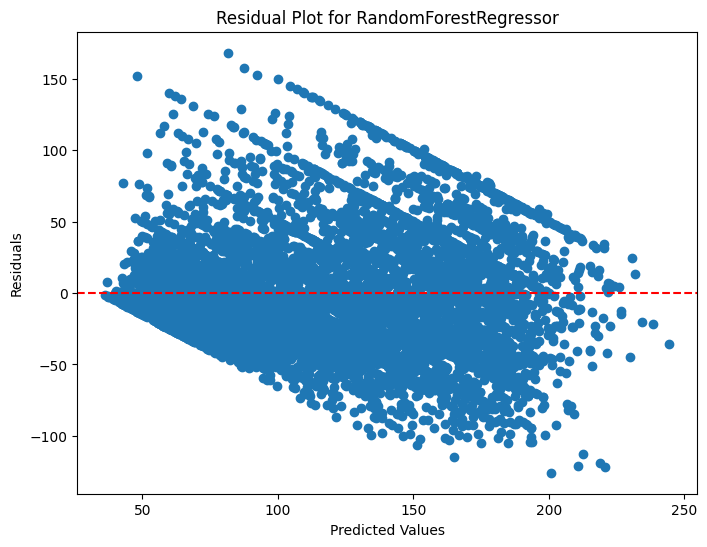

In [38]:
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)
results_rf = evaluate_model(rf_model, X_test, y_test)

### 05.2 - LinearRegression

Results for LinearRegression:
  RMSE: 38.3526
  MAE: 29.3510
  MSE: 1470.9201
  R²: 0.5371
  PVE: 0.5371
--------------------------------------------------


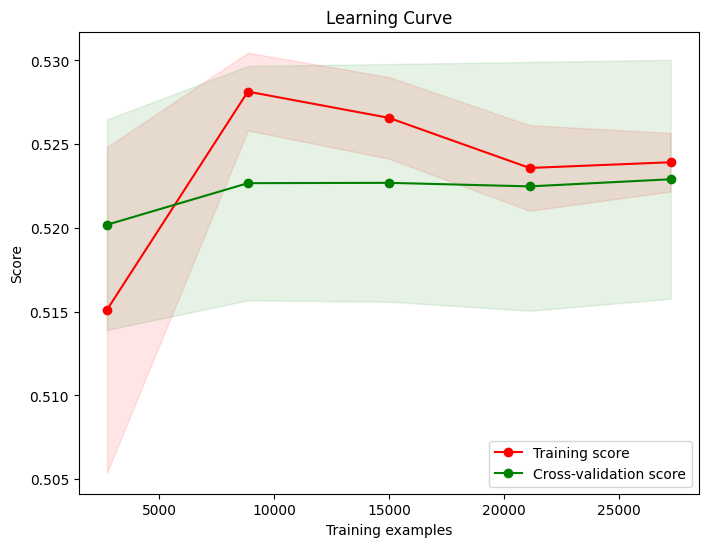

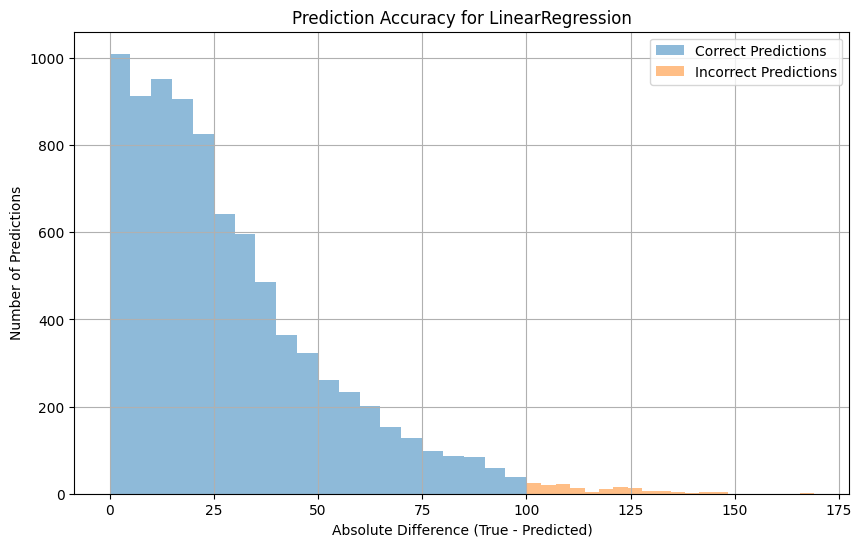

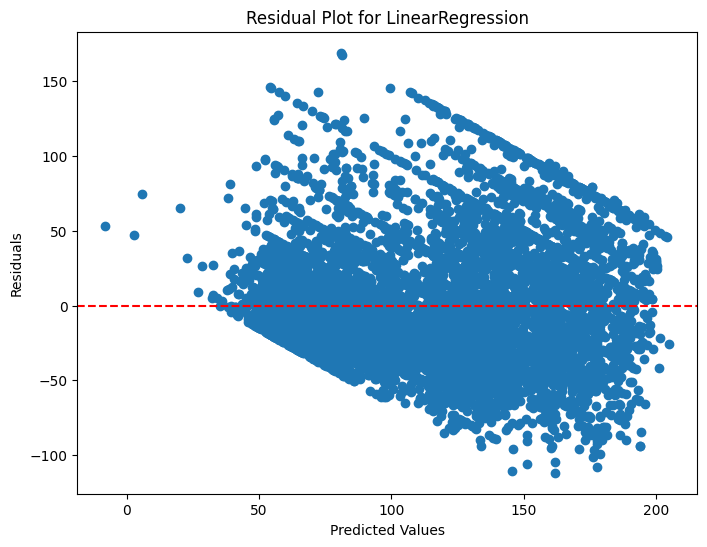

In [39]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
results_lr = evaluate_model(lr_model, X_test, y_test)

### 05.3 - GradientBoosting

Results for GradientBoostingRegressor:
  RMSE: 36.7879
  MAE: 27.9421
  MSE: 1353.3473
  R²: 0.5741
  PVE: 0.5741
--------------------------------------------------


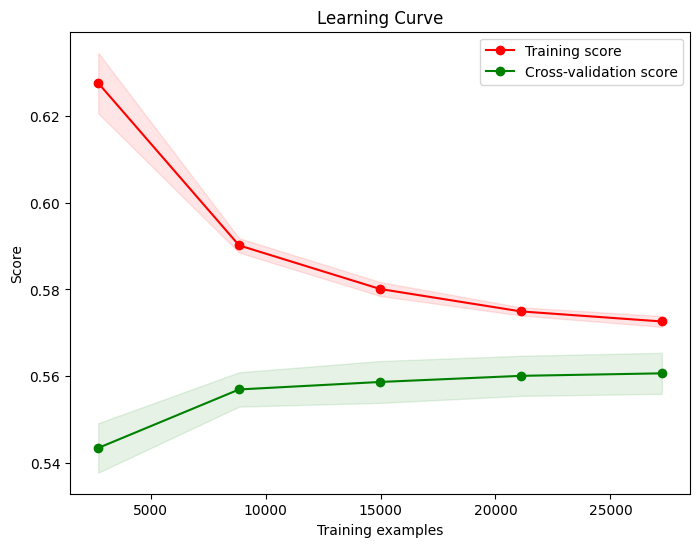

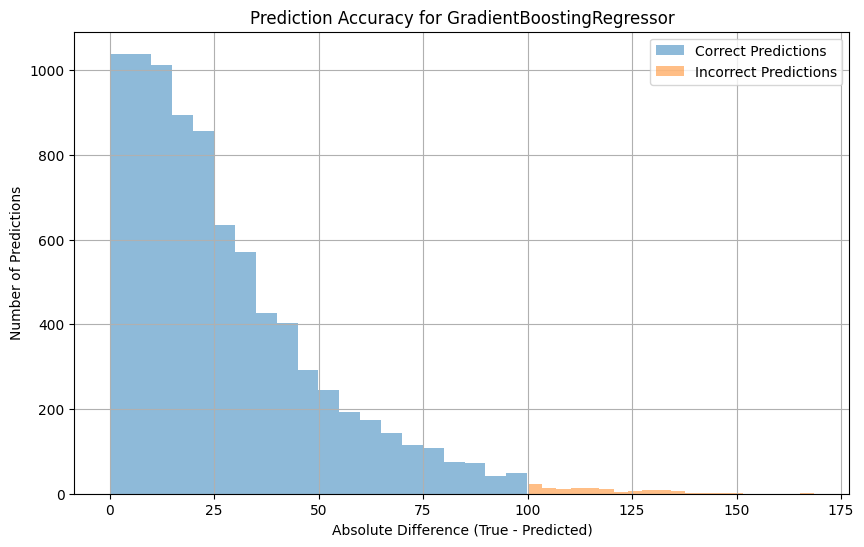

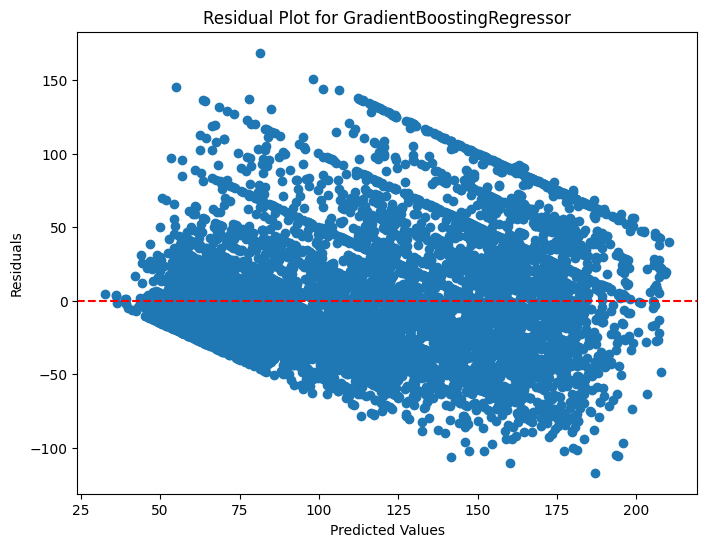

In [40]:
gb_model = GradientBoostingRegressor(random_state=42)
gb_model.fit(X_train, y_train)
results_gb = evaluate_model(gb_model, X_test, y_test)

### 05.4 - Ridge

Results for Ridge:
  RMSE: 38.3528
  MAE: 29.3507
  MSE: 1470.9384
  R²: 0.5371
  PVE: 0.5371
--------------------------------------------------


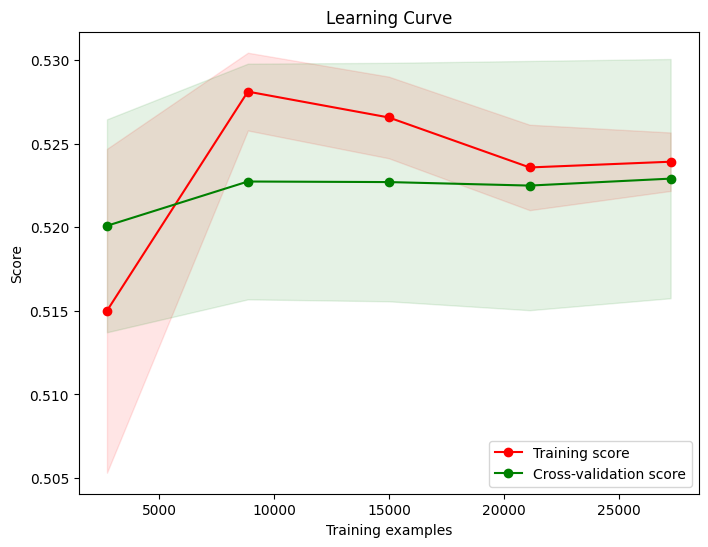

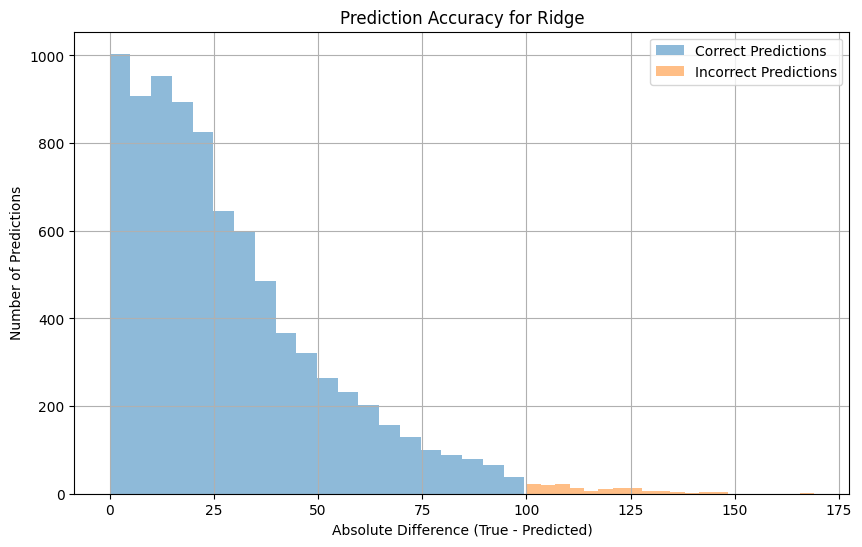

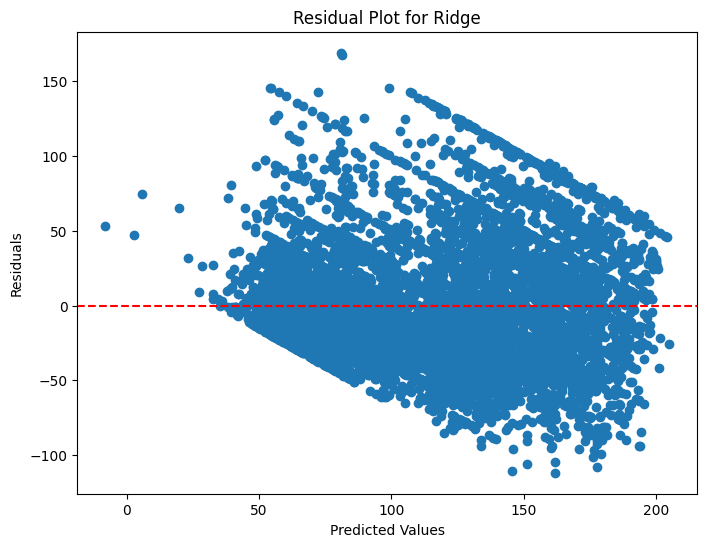

In [41]:
ridge_model = Ridge(random_state=42)
ridge_model.fit(X_train, y_train)
results_ridge = evaluate_model(ridge_model, X_test, y_test)

### 05.5 - Lasso

Results for Lasso:
  RMSE: 38.6993
  MAE: 29.7703
  MSE: 1497.6371
  R²: 0.5287
  PVE: 0.5287
--------------------------------------------------


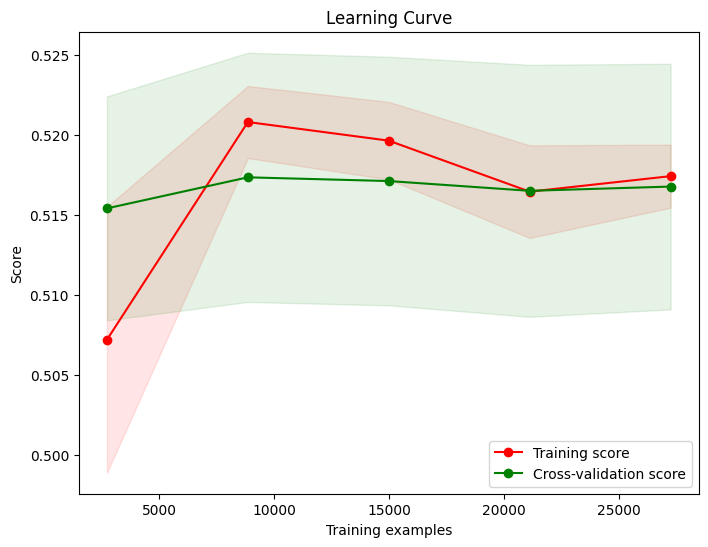

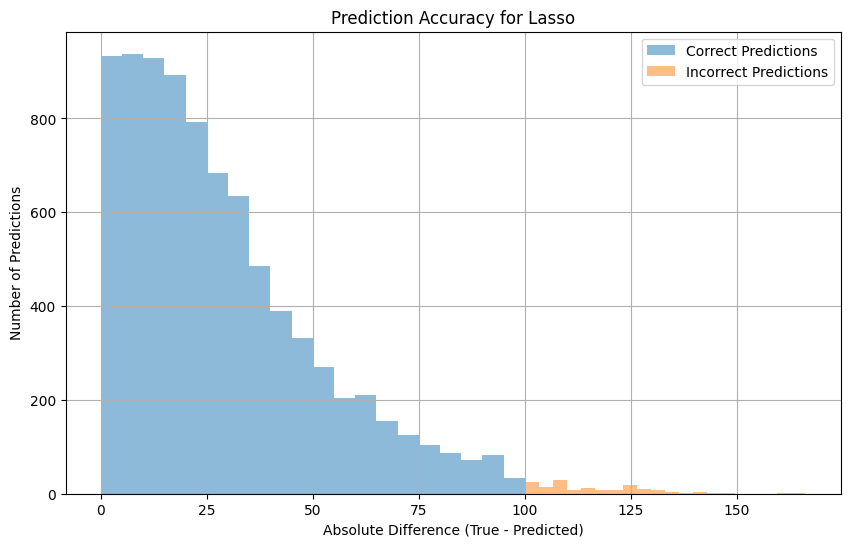

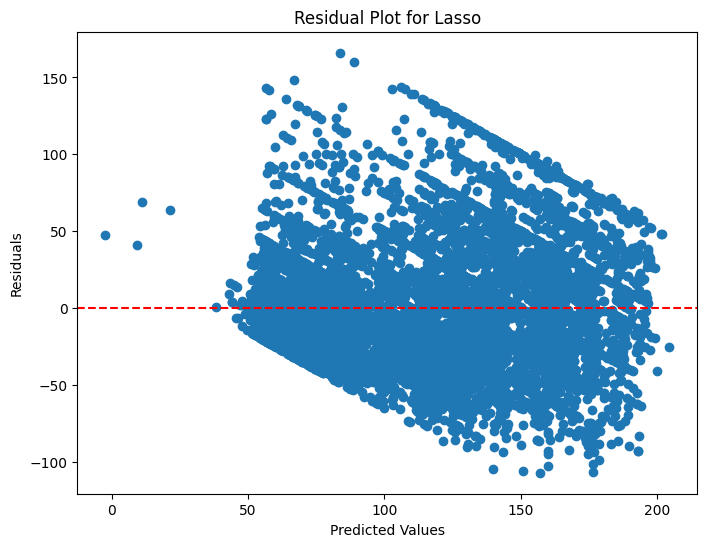

In [42]:
lasso_model = Lasso(random_state=42)
lasso_model.fit(X_train, y_train)
results_lasso = evaluate_model(lasso_model, X_test, y_test)

### 05.6 - ElasticNet

Results for ElasticNet:
  RMSE: 42.2326
  MAE: 33.2052
  MSE: 1783.5908
  R²: 0.4387
  PVE: 0.4387
--------------------------------------------------


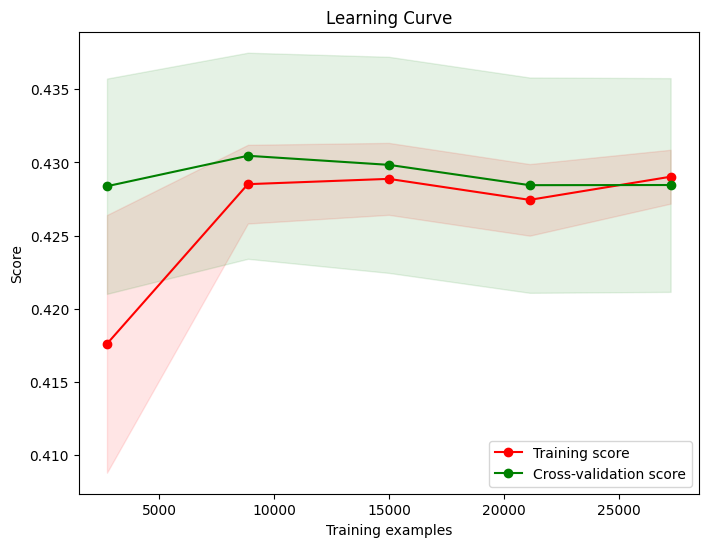

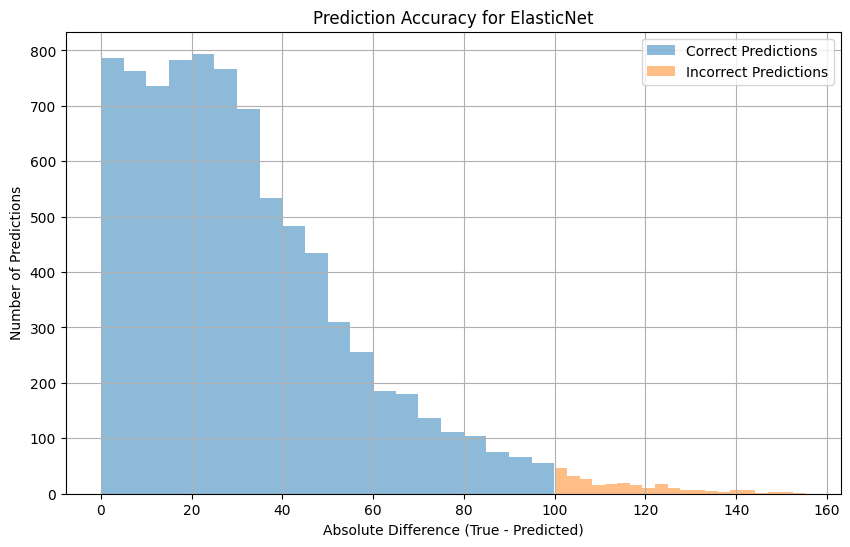

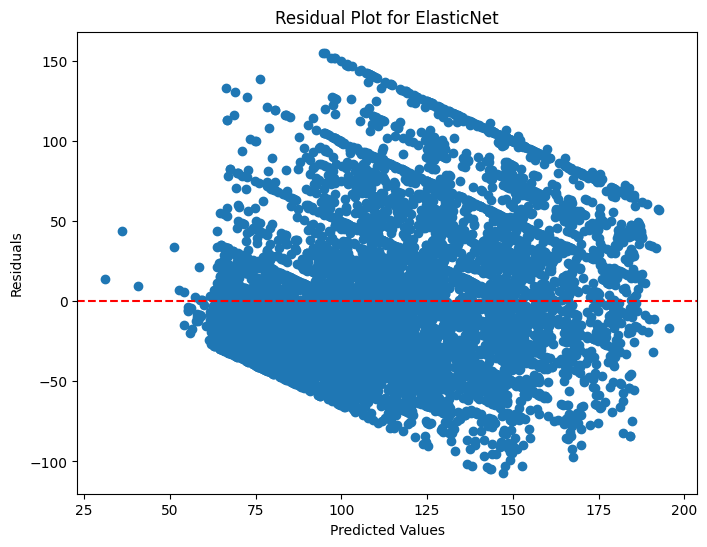

In [43]:
en_model = ElasticNet(random_state=42)
en_model.fit(X_train, y_train)
results_en = evaluate_model(en_model, X_test, y_test)

### 05.7 - DecisionTree

Results for DecisionTreeRegressor:
  RMSE: 52.0280
  MAE: 37.6778
  MSE: 2706.9084
  R²: 0.1481
  PVE: 0.1488
--------------------------------------------------


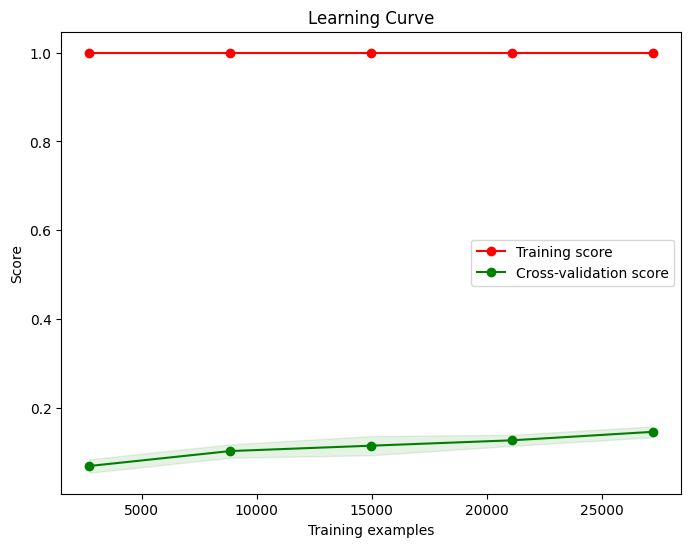

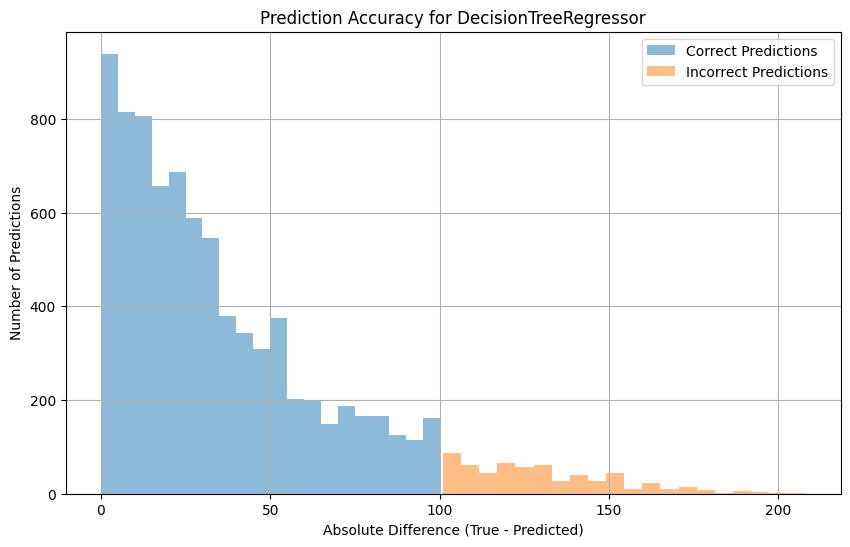

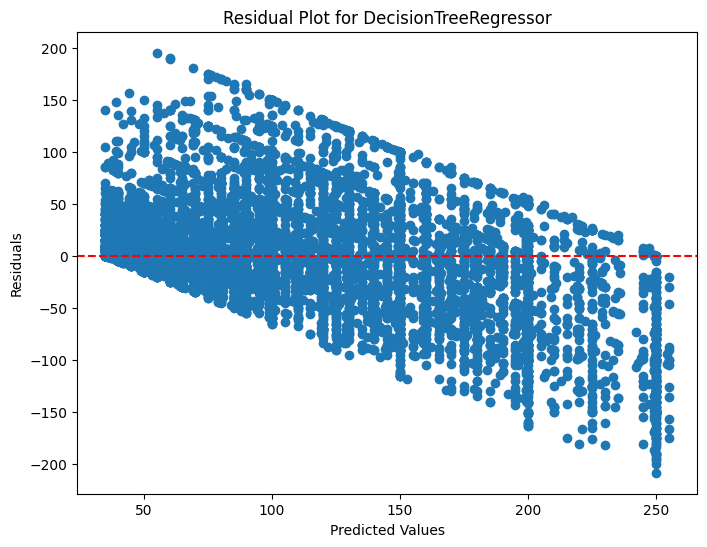

In [44]:
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)
results_dt = evaluate_model(dt_model, X_test, y_test)

### 05.8 - KNN

Results for KNeighborsRegressor:
  RMSE: 50.2561
  MAE: 39.6095
  MSE: 2525.6711
  R²: 0.2051
  PVE: 0.2052
--------------------------------------------------


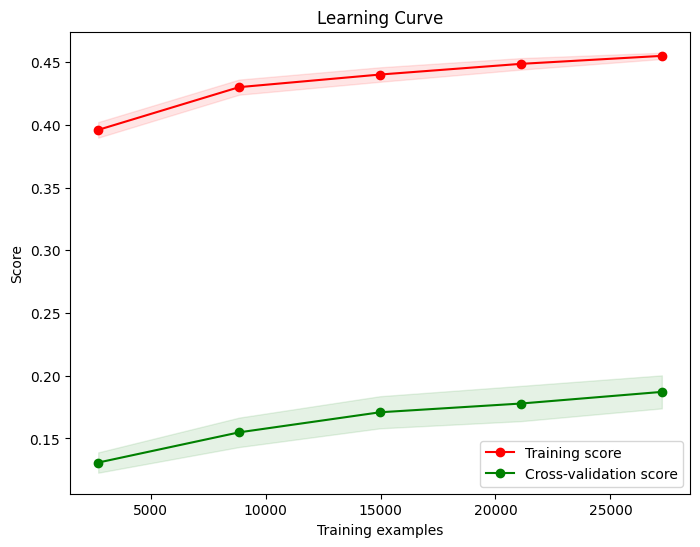

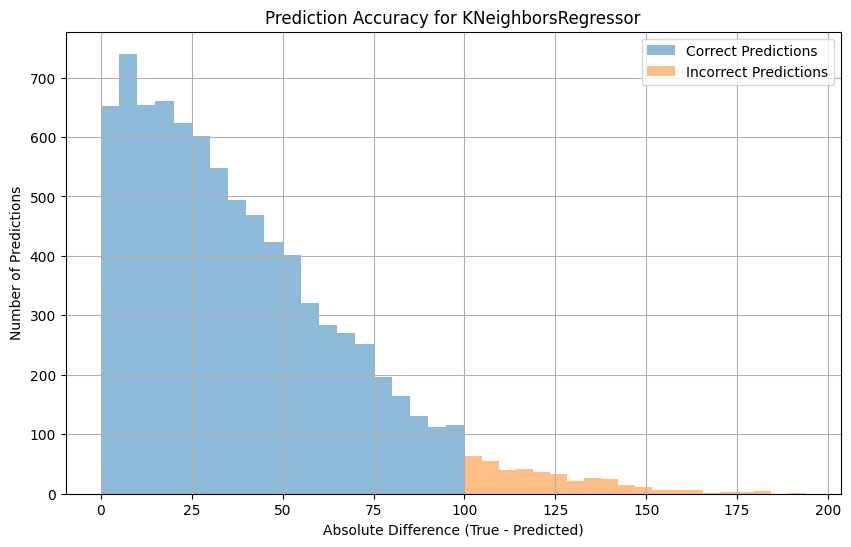

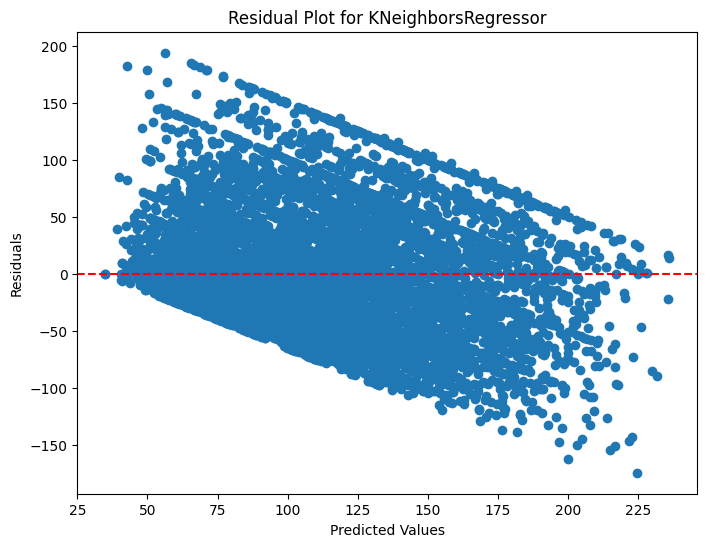

In [45]:
knn_model = KNeighborsRegressor()
knn_model.fit(X_train, y_train)
results_knn = evaluate_model(knn_model, X_test, y_test)

### 05.9 - AdaBoost

Results for AdaBoostRegressor:
  RMSE: 40.0291
  MAE: 32.5182
  MSE: 1602.3269
  R²: 0.4957
  PVE: 0.5192
--------------------------------------------------


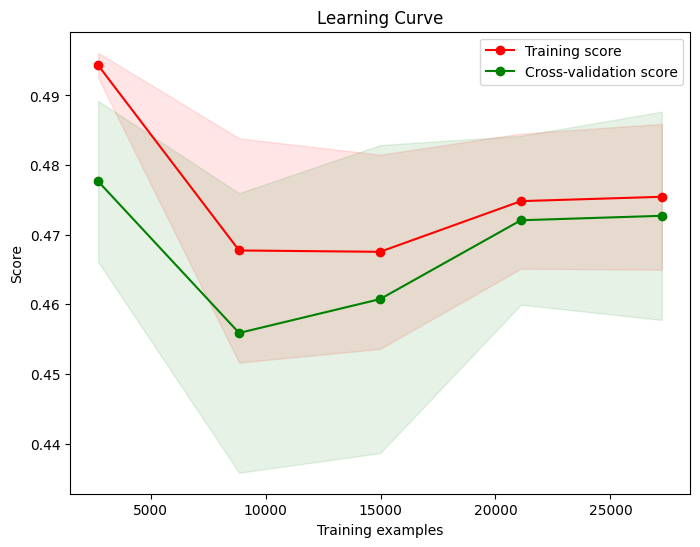

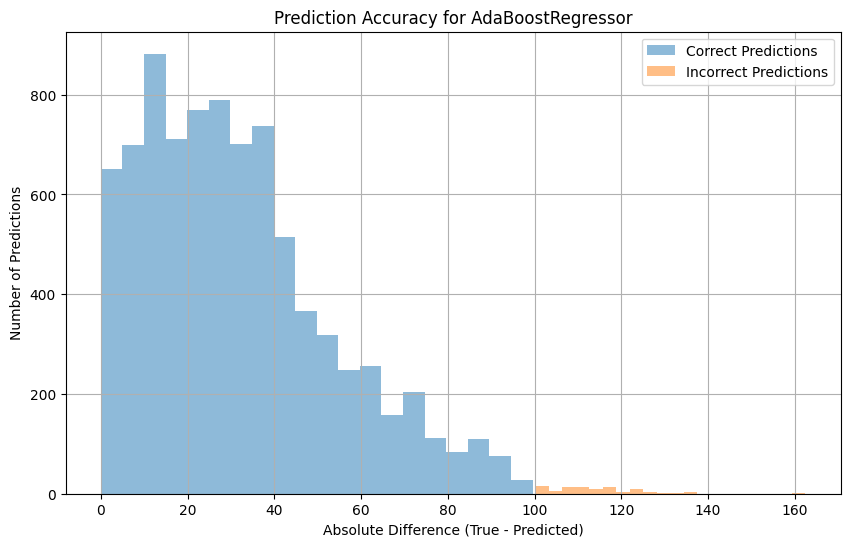

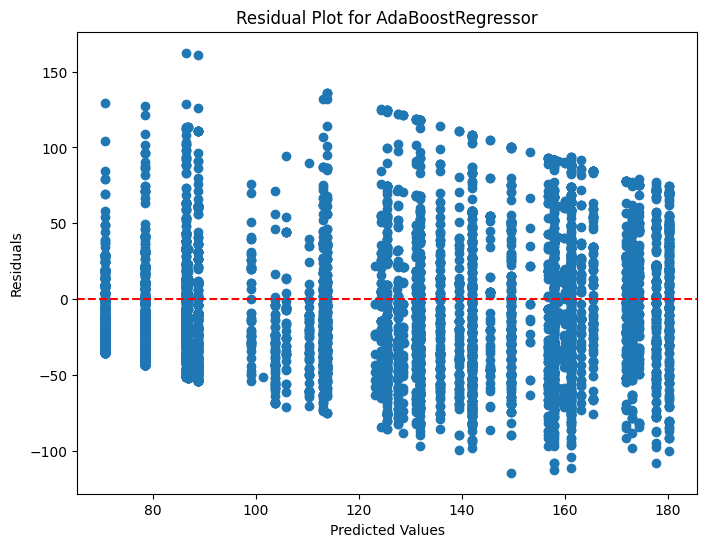

In [46]:
ab_model = AdaBoostRegressor(random_state=42)
ab_model.fit(X_train, y_train)
results_ab = evaluate_model(ab_model, X_test, y_test)

# 06 -Results

In [47]:
results_list = [results_rf, results_lr, results_gb, results_ridge, results_lasso, results_en, results_dt, results_knn, results_ab]
metrics = ['RMSE', 'MAE', 'MSE', 'R²', 'PVE']
df_results = pd.DataFrame(results_list, columns=metrics, index=['RandomForest', 'LinearRegression', 'GradientBoosting', 'Ridge', 'Lasso', 'ElasticNet', 'DecisionTree', 'KNN', 'AdaBoost'])

df_results

,RMSE,MAE,MSE,R²,PVE
RandomForest,36.835172,27.760229,1356.829930,0.572988,0.573579
LinearRegression,38.352576,29.350967,1470.920056,0.537083,0.537113
GradientBoosting,36.787869,27.942090,1353.347270,0.574084,0.574132
Ridge,38.352815,29.350700,1470.938425,0.537077,0.537107
Lasso,38.699316,29.770254,1497.637091,0.528674,0.528709
ElasticNet,42.232580,33.205191,1783.590775,0.438681,0.438707
DecisionTree,52.027958,37.677809,2706.908380,0.148101,0.148778
KNN,50.256056,39.609524,2525.671122,0.205139,0.205160
AdaBoost,40.029076,32.518188,1602.326913,0.495727,0.519209


**Why Random Forest?**

The Random Forest model was selected for the following advantages:

- High accuracy: Random Forest generally exhibits high accuracy in regression tasks.
- Robustness: It is robust to outliers and noisy data.
- Flexibility: It can handle numerical and categorical variables.
- Interpretability: It allows for analyzing the importance of variables.

**Why RMSE as a Metric?**

RMSE (Root Mean Squared Error) was used as the primary metric because:

- Penalizes large errors: RMSE gives more weight to larger errors.
- Easy interpretation: RMSE is expressed in the same unit as the target variable.
- Widely used: It is a standard metric for evaluating regression models.

In [48]:
data_encoded.columns

Index(['bairro_group_Bronx', 'bairro_group_Brooklyn', 'bairro_group_Manhattan',
       'bairro_group_Queens', 'bairro_group_Staten Island',
       'room_type_Entire home/apt', 'room_type_Private room',
       'room_type_Shared room', 'latitude', 'longitude', 'price',
       'minimo_noites', 'numero_de_reviews', 'reviews_por_mes',
       'disponibilidade_365', 'ano_ultima_review', 'mes_ultima_review',
       'dia_ultima_review', 'bairro_encoded'],
      dtype='object')

In [49]:
bairro_mapping

{'Midtown': 159.3131634819533,
 'Harlem': 99.15975855130785,
 'Clinton Hill': 118.11867704280155,
 'East Harlem': 106.75722543352602,
 'Murray Hill': 163.63717602593283,
 'Bedford-Stuyvesant': 93.41971287514525,
 "Hell's Kitchen": 145.01181102362204,
 'Upper West Side': 135.05227552275522,
 'Chinatown': 128.23999999999913,
 'South Slope': 126.84883720864475,
 'West Village': 175.14468864468864,
 'Williamsburg': 115.23539152612629,
 'Fort Greene': 125.32118451025057,
 'Chelsea': 159.3411910669975,
 'Crown Heights': 95.69446391030134,
 'Park Slope': 135.38268792710707,
 'Windsor Terrace': 117.0992656984435,
 'Inwood': 86.03765691195066,
 'East Village': 139.3758774728781,
 'Greenpoint': 118.933935265823,
 'Bushwick': 80.2784645140831,
 'Flatbush': 82.52430555555556,
 'Lower East Side': 133.54060913705584,
 'Prospect-Lefferts Gardens': 94.1304347826087,
 'Long Island City': 106.18346774193549,
 'Kips Bay': 139.38069705093835,
 'SoHo': 153.40663899384663,
 'Upper East Side': 140.5035324341

# 07 - Testing

In [50]:
id_widget = widgets.Text(description="ID:")
name_widget = widgets.Text(description="Name:")
host_id_widget = widgets.Text(description="Host ID:")
host_name_widget = widgets.Text(description="Host Name:")
latitude_widget = widgets.FloatText(description="Latitude:")
longitude_widget = widgets.FloatText(description="Longitude:")


neighborhood_group_options = [option.replace('bairro_group_', '') for option in data_encoded.columns
                               if option.startswith('bairro_group_')]
neighborhood_group_widget = widgets.Dropdown(options=neighborhood_group_options, description="Neighborhood Group:")

neighborhood_options = list(bairro_mapping.keys())
neighborhood_widget = widgets.Dropdown(options=neighborhood_options, description="Neighborhood:")

room_type_options = [option.replace('room_type_', '') for option in data_encoded.columns
                         if option.startswith('room_type_')]
room_type_widget = widgets.Dropdown(options=room_type_options, description="Room Type:")

minimum_nights_widget = widgets.IntSlider(min=1, max=10000, description="Minimum Nights:")
number_of_reviews_widget = widgets.IntSlider(min=0, max=10000, description="Number of Reviews:")
reviews_per_month_widget = widgets.FloatSlider(min=0, max=10000, description="Reviews per Month:")
availability_365_widget = widgets.IntSlider(min=0, max=365, description="Availability 365:")


last_review_widget = widgets.DatePicker(description="Last Review:")

In [51]:
def predict_price(
    id, name, host_id, host_name, neighborhood_group, neighborhood, latitude, longitude, room_type,
    minimum_nights, number_of_reviews, last_review, reviews_per_month,
    availability_365
):
    year = int(last_review.year)
    month = int(last_review.month)
    day = int(last_review.day)

    property_data = pd.DataFrame({
        'bairro_group_Bronx': [0],
        'bairro_group_Brooklyn': [0],
        'bairro_group_Manhattan': [0],
        'bairro_group_Queens': [0],
        'bairro_group_Staten Island': [0],
        'room_type_Entire home/apt': [0],
        'room_type_Private room': [0],
        'room_type_Shared room': [0],

        'latitude': [latitude],
        'longitude': [longitude],
        'minimo_noites': [minimum_nights],
        'numero_de_reviews': [number_of_reviews],
        'reviews_por_mes': [reviews_per_month],
        'disponibilidade_365': [availability_365],
        'bairro_encoded': [bairro_mapping[neighborhood]],

        'ano_ultima_review': [year],
        'mes_ultima_review': [month],
        'dia_ultima_review': [day],

        })

    property_data[f'bairro_group_{neighborhood_group}'] = 1
    property_data[f'room_type_{room_type}'] = 1

    prediction_cols = ['bairro_group_Bronx', 'bairro_group_Brooklyn', 'bairro_group_Manhattan',
                       'bairro_group_Queens', 'bairro_group_Staten Island',
                       'room_type_Entire home/apt', 'room_type_Private room',
                       'room_type_Shared room', 'latitude', 'longitude',
                       'minimo_noites', 'numero_de_reviews', 'reviews_por_mes',
                       'disponibilidade_365', 'ano_ultima_review', 'mes_ultima_review',
                       'dia_ultima_review', 'bairro_encoded']

    property_data_for_prediction = property_data[prediction_cols]

    predicted_price = rf_model.predict(property_data_for_prediction)[0]

    print(f"Predicted Price: R$ {predicted_price:.2f}")

In [52]:
predict_button = widgets.Button(description="Predict Price")

def on_button_clicked(b):
    predict_price(
        id_widget.value, name_widget.value, host_id_widget.value, host_name_widget.value,
        neighborhood_group_widget.value, neighborhood_widget.value, latitude_widget.value, longitude_widget.value,
        room_type_widget.value, minimum_nights_widget.value, number_of_reviews_widget.value,
        last_review_widget.value, reviews_per_month_widget.value,
        availability_365_widget.value
    )

predict_button.on_click(on_button_clicked)

In [53]:
display(
    id_widget, name_widget, host_id_widget, host_name_widget, neighborhood_group_widget,
    neighborhood_widget, latitude_widget, longitude_widget, room_type_widget,
    minimum_nights_widget, number_of_reviews_widget, last_review_widget,
    reviews_per_month_widget,
    availability_365_widget, predict_button
)

Text(value='', description='ID:')

Text(value='', description='Name:')

Text(value='', description='Host ID:')

Text(value='', description='Host Name:')

Dropdown(description='Neighborhood Group:', options=('Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Islan…

Dropdown(description='Neighborhood:', options=('Midtown', 'Harlem', 'Clinton Hill', 'East Harlem', 'Murray Hil…

FloatText(value=0.0, description='Latitude:')

FloatText(value=0.0, description='Longitude:')

Dropdown(description='Room Type:', options=('Entire home/apt', 'Private room', 'Shared room'), value='Entire h…

IntSlider(value=1, description='Minimum Nights:', max=10000, min=1)

IntSlider(value=0, description='Number of Reviews:', max=10000)

DatePicker(value=None, description='Last Review:')

FloatSlider(value=0.0, description='Reviews per Month:', max=10000.0)

IntSlider(value=0, description='Availability 365:', max=365)

Button(description='Predict Price', style=ButtonStyle())

In [73]:
bairro_mapping

{'Midtown': 159.3131634819533,
 'Harlem': 99.15975855130785,
 'Clinton Hill': 118.11867704280155,
 'East Harlem': 106.75722543352602,
 'Murray Hill': 163.63717602593283,
 'Bedford-Stuyvesant': 93.41971287514525,
 "Hell's Kitchen": 145.01181102362204,
 'Upper West Side': 135.05227552275522,
 'Chinatown': 128.23999999999913,
 'South Slope': 126.84883720864475,
 'West Village': 175.14468864468864,
 'Williamsburg': 115.23539152612629,
 'Fort Greene': 125.32118451025057,
 'Chelsea': 159.3411910669975,
 'Crown Heights': 95.69446391030134,
 'Park Slope': 135.38268792710707,
 'Windsor Terrace': 117.0992656984435,
 'Inwood': 86.03765691195066,
 'East Village': 139.3758774728781,
 'Greenpoint': 118.933935265823,
 'Bushwick': 80.2784645140831,
 'Flatbush': 82.52430555555556,
 'Lower East Side': 133.54060913705584,
 'Prospect-Lefferts Gardens': 94.1304347826087,
 'Long Island City': 106.18346774193549,
 'Kips Bay': 139.38069705093835,
 'SoHo': 153.40663899384663,
 'Upper East Side': 140.5035324341

In [71]:
def save_to_json(variable, file_path):
  file_path = os.path.join('/content/drive/MyDrive/Colab Notebooks/Insidium/mapping/', file_path)
  os.makedirs(os.path.dirname(file_path), exist_ok=True)
  with open(file_path, 'w') as f:
        json.dump(variable, f, indent=4)

In [74]:
bairro_group_options = data['bairro_group'].unique().tolist()
room_type_options = data['room_type'].unique().tolist()


In [75]:
save_to_json(bairro_group_options, 'bairro_group_options.json')
save_to_json(room_type_options, 'room_type_options.json')
save_to_json(bairro_mapping, 'bairro_mapping.json')